# Letal COVID-19 snRNA Analysis
# Section 4: Dimensionality Reduction
Author: MikiasHWT  
Start: December 9, 2024  

In [78]:
from datetime import datetime
current_date = datetime.now().strftime("%B %d, %Y")
print(f"Updated: {current_date}")

Updated: December 20, 2024


# Background

Once we have subset our genes to the most informative subsets, we are still left with more genes than the human mind can easily comprehend. Additionally high dimensional data does not always mean informative data, much of the information we have on hand could be a product of noise and various other artifacts. This is where unsupervised machine learning methods such as clustering and dimensionality reduction come into play. These methods take the 2000+/- genes in our data and without any labels to inform grouping (unsupervised) they apply various statistical methods to reduce the number of dimensions to a handful of informative dimensions. 

## Objective

- Reduce the number of dimensions in the data
- Compare various methods
- Cluster by cell types
- Determine appropriate resolutions

# Prep Workspace

## Import Libraries

In [79]:
# Default 
import numpy as np  # Numerical computing library
import pandas as pd  # Data manipulation and analysis
import matplotlib.pyplot as plt  # Plotting and visualization
import seaborn as sns  # Statistical data visualization
import scanpy as sc  # Single-cell data analysis
import os  # Operating system interface

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
    figsize=(8, 6)  
)

## Directories

In [80]:
# Define directories 
datDir = os.path.abspath("data")
outDir = os.path.abspath("output")

## Import Data

In [81]:
# Read single sample we QC'd & Normalized in previous sections
adata = sc.read_h5ad("data/C51ctr_HVG.h5ad")
adata

AnnData object with n_obs × n_vars = 6094 × 24660
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'size_factors'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_deviant', 'binomial_deviance', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'outlier_temp_colors'
    layers: 'counts', 'log1p-CP10K', 'log1p-CPM', 'log1p-median', 'pearson_residuals', 'scran_normalization'

## Markers of Interest

In [82]:
# Common markers List to compare feature selection methods
markers = ["HLA-E", "CD4", "PTPRC", "IGHM", "ITGAX"]

# Clustering & Dimensionality Reduction

## PCA

As always various methods exist and are continuesly refined. Some default apporaches include:

- `Principle Component Analysis (PCA)`: Finds linear combinations of features that maximaize variance and groups them into sets of principle components.
    - An old method but still widely used
    - Excellent for reducing dimensinality for downstream workflows. 
    - Not great with visualization

In [83]:
# Compute Principle Components with logp1 scaled values and ensure highly variable boolean mask is used
sc.pp.pca(adata, svd_solver="arpack", layer='log1p-median', mask_var="highly_variable")
adata

AnnData object with n_obs × n_vars = 6094 × 24660
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'size_factors'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_deviant', 'binomial_deviance', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'outlier_temp_colors', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'log1p-CP10K', 'log1p-CPM', 'log1p-median', 'pearson_residuals', 'scran_normalization'

We note that we have included additional variables into our Anndata object after running PCA. Specifically we have the default addition of 50 Priniciple Components. 

In [84]:
adata.uns["pca"]

{'params': {'zero_center': True,
  'use_highly_variable': True,
  'mask_var': 'highly_variable',
  'layer': 'log1p-median'},
 'variance': array([10.9729    ,  8.217189  ,  6.5804315 ,  5.490265  ,  4.84445   ,
         3.2803044 ,  1.8329126 ,  1.2608949 ,  1.2236134 ,  1.1461061 ,
         0.9289614 ,  0.74373794,  0.71534395,  0.5933714 ,  0.49749452,
         0.48454276,  0.45522478,  0.41936278,  0.39740986,  0.36706224,
         0.32883176,  0.3159144 ,  0.30394652,  0.2924706 ,  0.28466377,
         0.26571584,  0.2610234 ,  0.25539705,  0.24929486,  0.24637762,
         0.24108167,  0.23338804,  0.2303447 ,  0.22846666,  0.22605036,
         0.222744  ,  0.21979728,  0.21724167,  0.2130742 ,  0.2087069 ,
         0.20531859,  0.20476949,  0.20122887,  0.2005362 ,  0.19794746,
         0.1966055 ,  0.1935954 ,  0.19236444,  0.19011053,  0.18948384],
       dtype=float32),
 'variance_ratio': array([0.06885631, 0.05156388, 0.04129303, 0.0344521 , 0.03039953,
        0.02058432, 0.0

We can use a variance ratio plot (aka: elbow plot) to visualize the impact of each PC on the variance of the data. The Y-Axis denotes the amount of variance that the given X value describes. This plot can be used to identify the number of PC's that provide meaningful insight into the data, this is done by identifying the elbox joint in the plot (the point in the plot where additional PC's do not account for much more variability in the data). In the spirit of permissive filtering, it is accepted practice to slightly overshoot the elbow point. In the plot below, i might select anywhere from 10-20 PC's to move forward with the analysis. Experts generally agree that the choice of number of PC's isnt incredibly important to final outcome of analysis. 

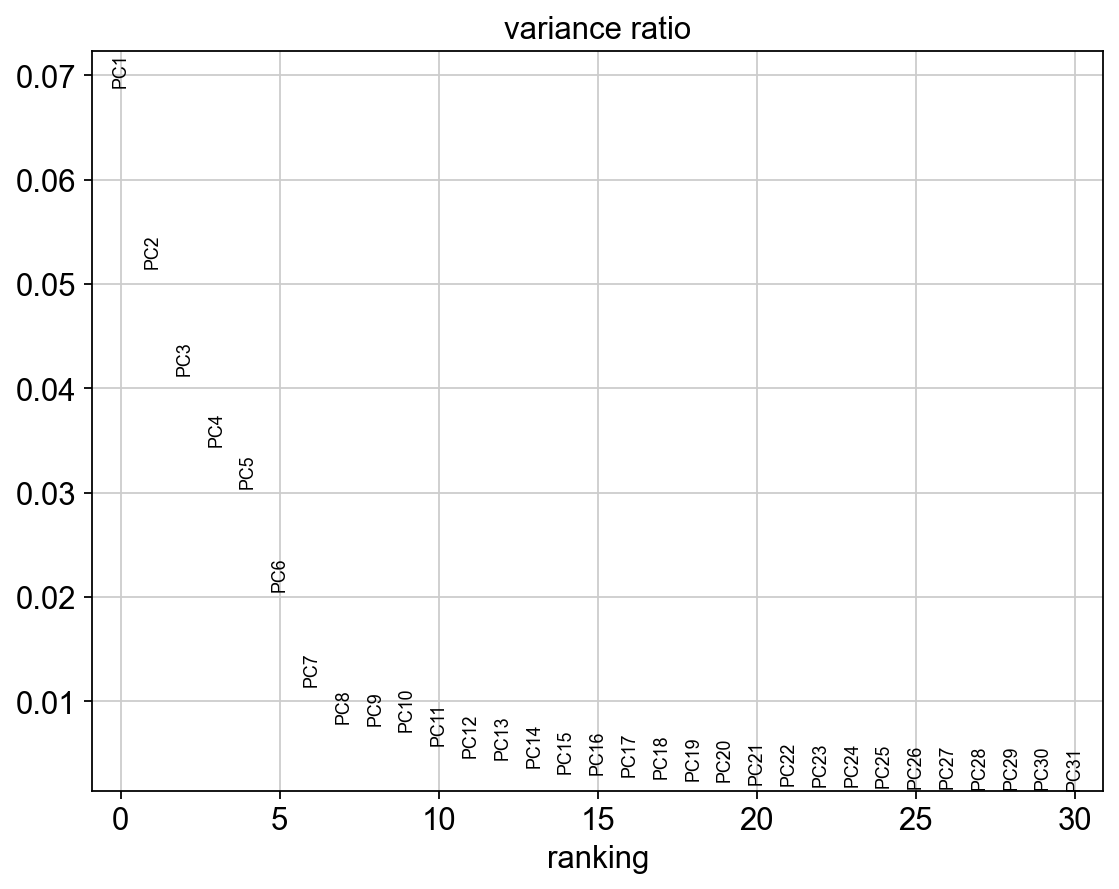

In [85]:
# Plot elbow curve
sc.pl.pca_variance_ratio(adata)

Additionally we can inspect the PCA loadings to determine the genes and their linear combinations that are influencing our first few PC's. 

c:\Users\Owner\Documents\GitHub\scRNA_Lethal_Covid19_Analysis\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8942 (\N{VERTICAL ELLIPSIS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


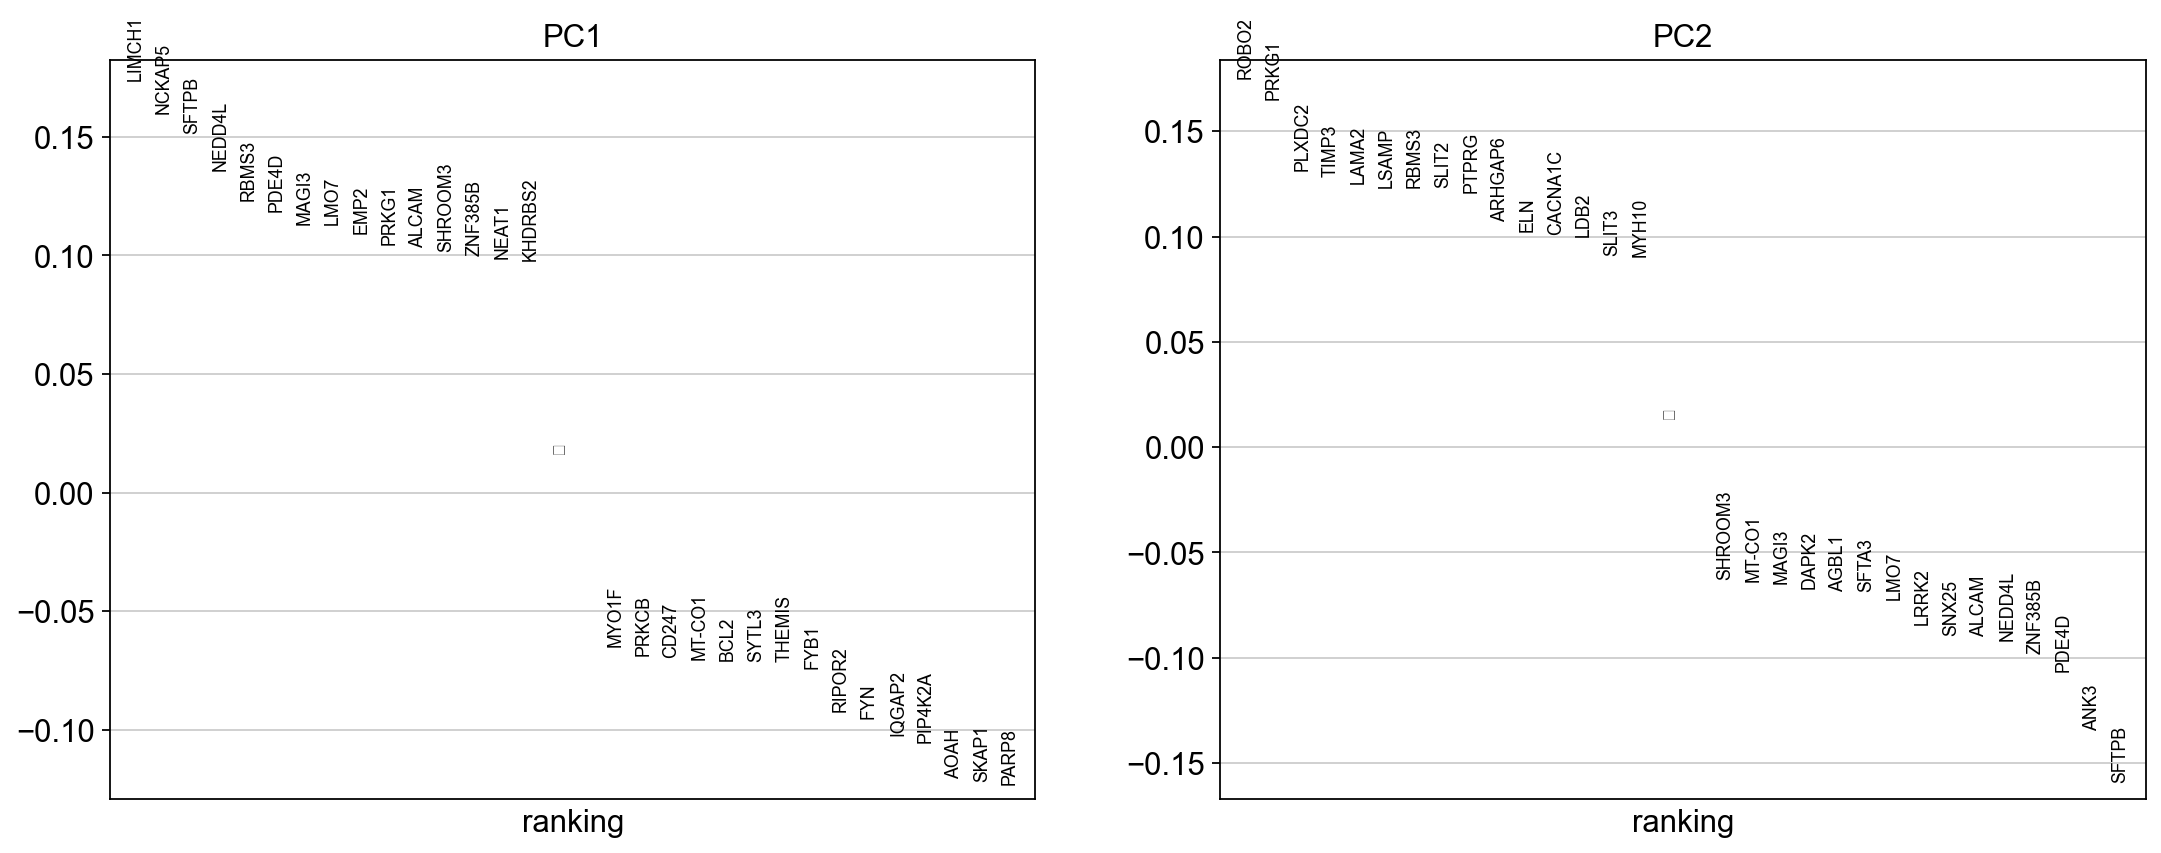

In [86]:
sc.pl.pca_loadings(adata, components = '1,2');

Lastly we can plot the first two PC's (or any others) to visualize how well the cells are groups. (this result is generally not very informative)

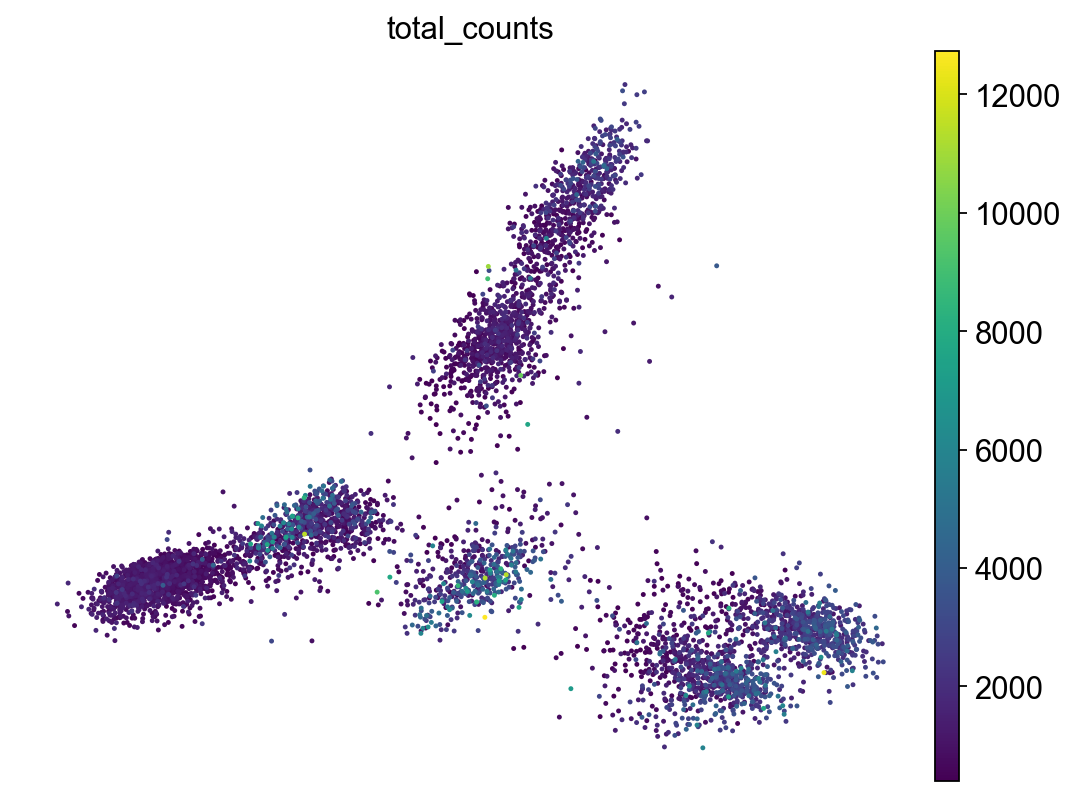

In [87]:
# Visualize
sc.pl.pca_scatter(adata, color="total_counts")

## tSNE

- `Stochastic Neighbor Embedding (tSNE)`: Uses pair wise similarties to reduce the dimensionaity of data
    - Can be computationally expensive for large datasets

In [88]:
# Apply tSNE
sc.tl.tsne(adata, use_rep="X_pca")
adata

AnnData object with n_obs × n_vars = 6094 × 24660
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'size_factors'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_deviant', 'binomial_deviance', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'outlier_temp_colors', 'pca', 'tsne'
    obsm: 'X_pca', 'X_tsne'
    varm: 'PCs'
    layers: 'counts', 'log1p-CP10K', 'log1p-CPM', 'log1p-median', 'pearson_residuals', 'scran_normalization'

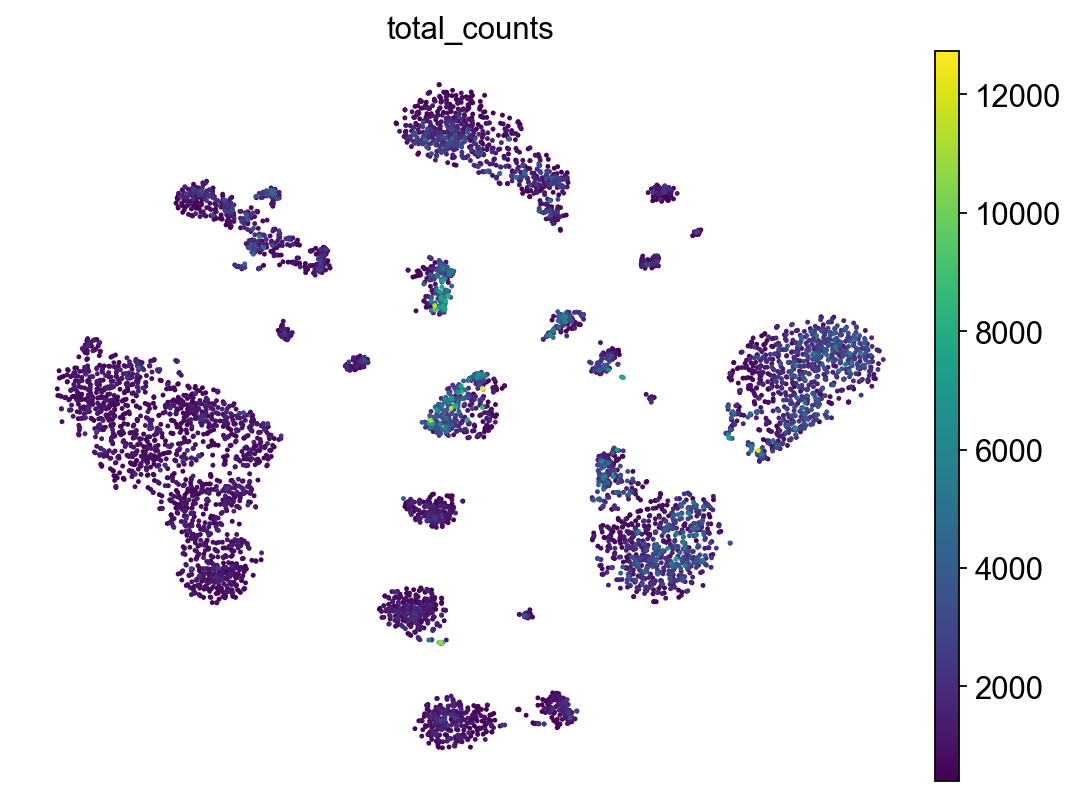

In [89]:
# Visualize tSNE
sc.pl.tsne(adata, color="total_counts")

## UMAP

- `Uniform Manifold Approximation and Projection (UMAP)`: Applies k-nearest neighbors approach to high dimensional data. 
    - Highly stable and does an excelent job at seperating cell types

In [90]:
# UMAP
sc.pp.neighbors(adata)
sc.tl.umap(adata)
adata

AnnData object with n_obs × n_vars = 6094 × 24660
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'size_factors'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_deviant', 'binomial_deviance', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'outlier_temp_colors', 'pca', 'tsne', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'log1p-CP10K', 'log1p-CPM', 'log1p-median', 'pearson_residuals', 'scran_normalization'
    obsp: 'distances', 'connectivities'

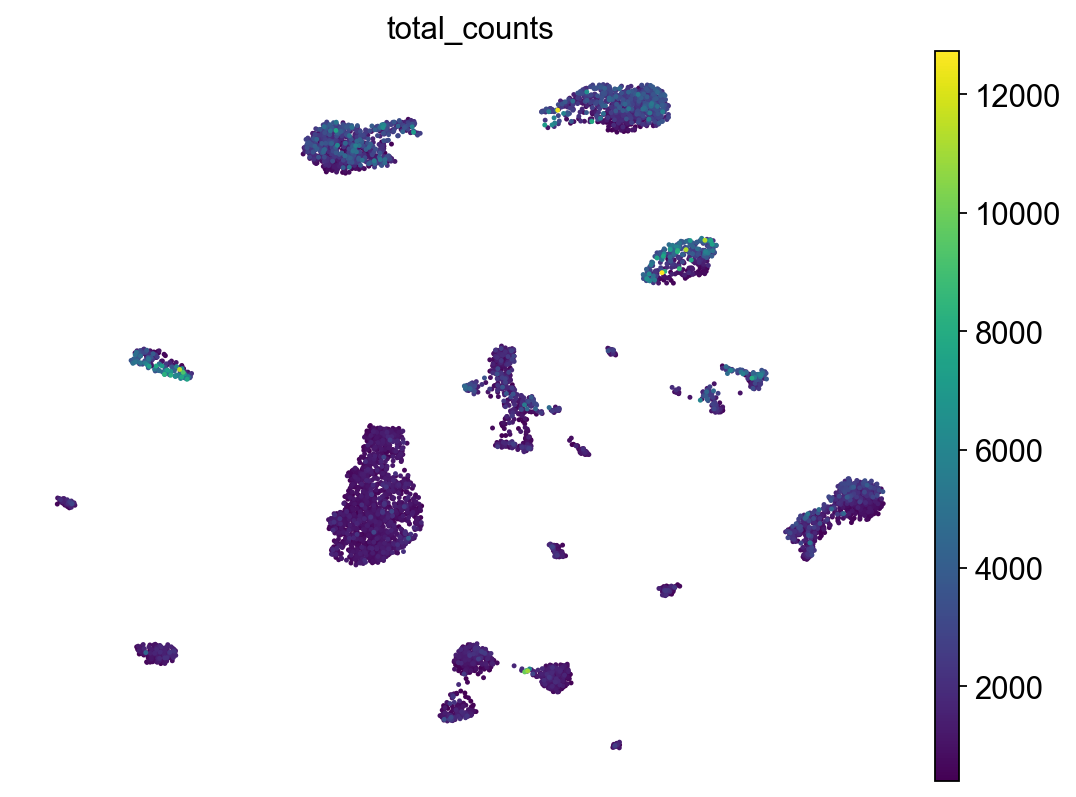

In [91]:
# Plot
sc.pl.umap(adata, color="total_counts")

## Explore Data

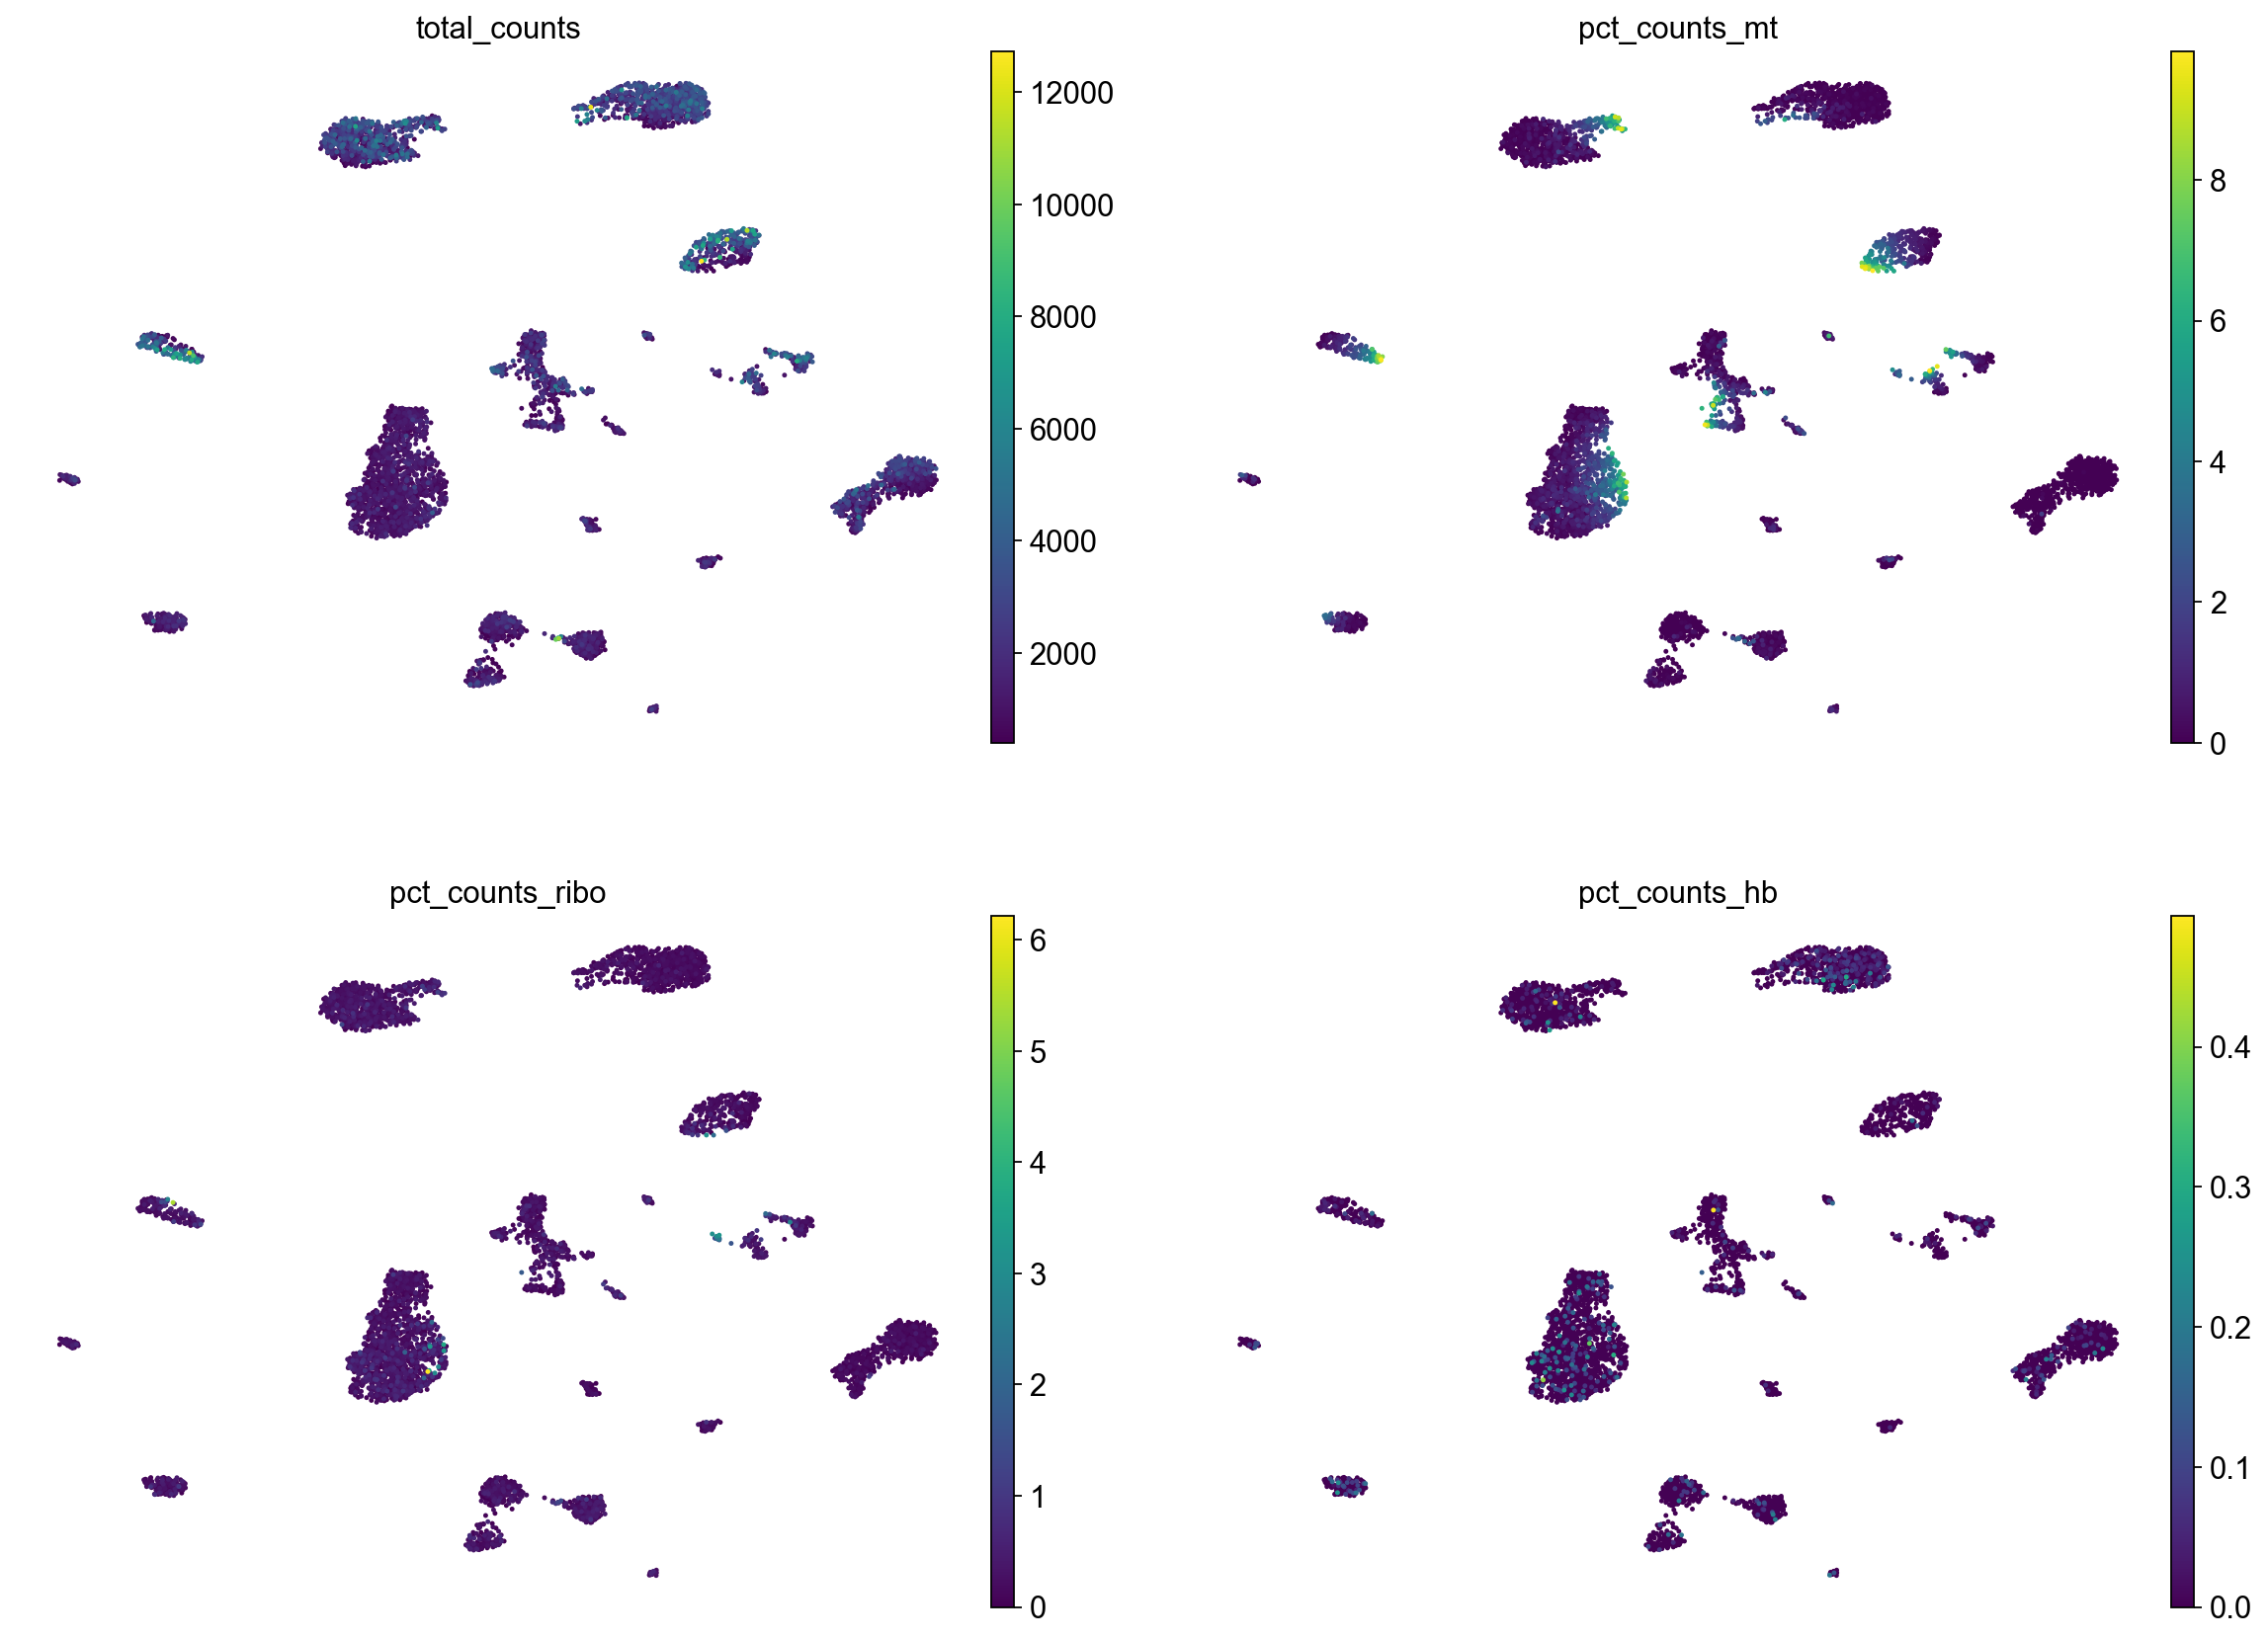

In [92]:
# Inspect quality control 
sc.pl.umap(
    adata,
    color=["total_counts", "pct_counts_mt", "pct_counts_ribo", "pct_counts_hb"],
    ncols=2
)

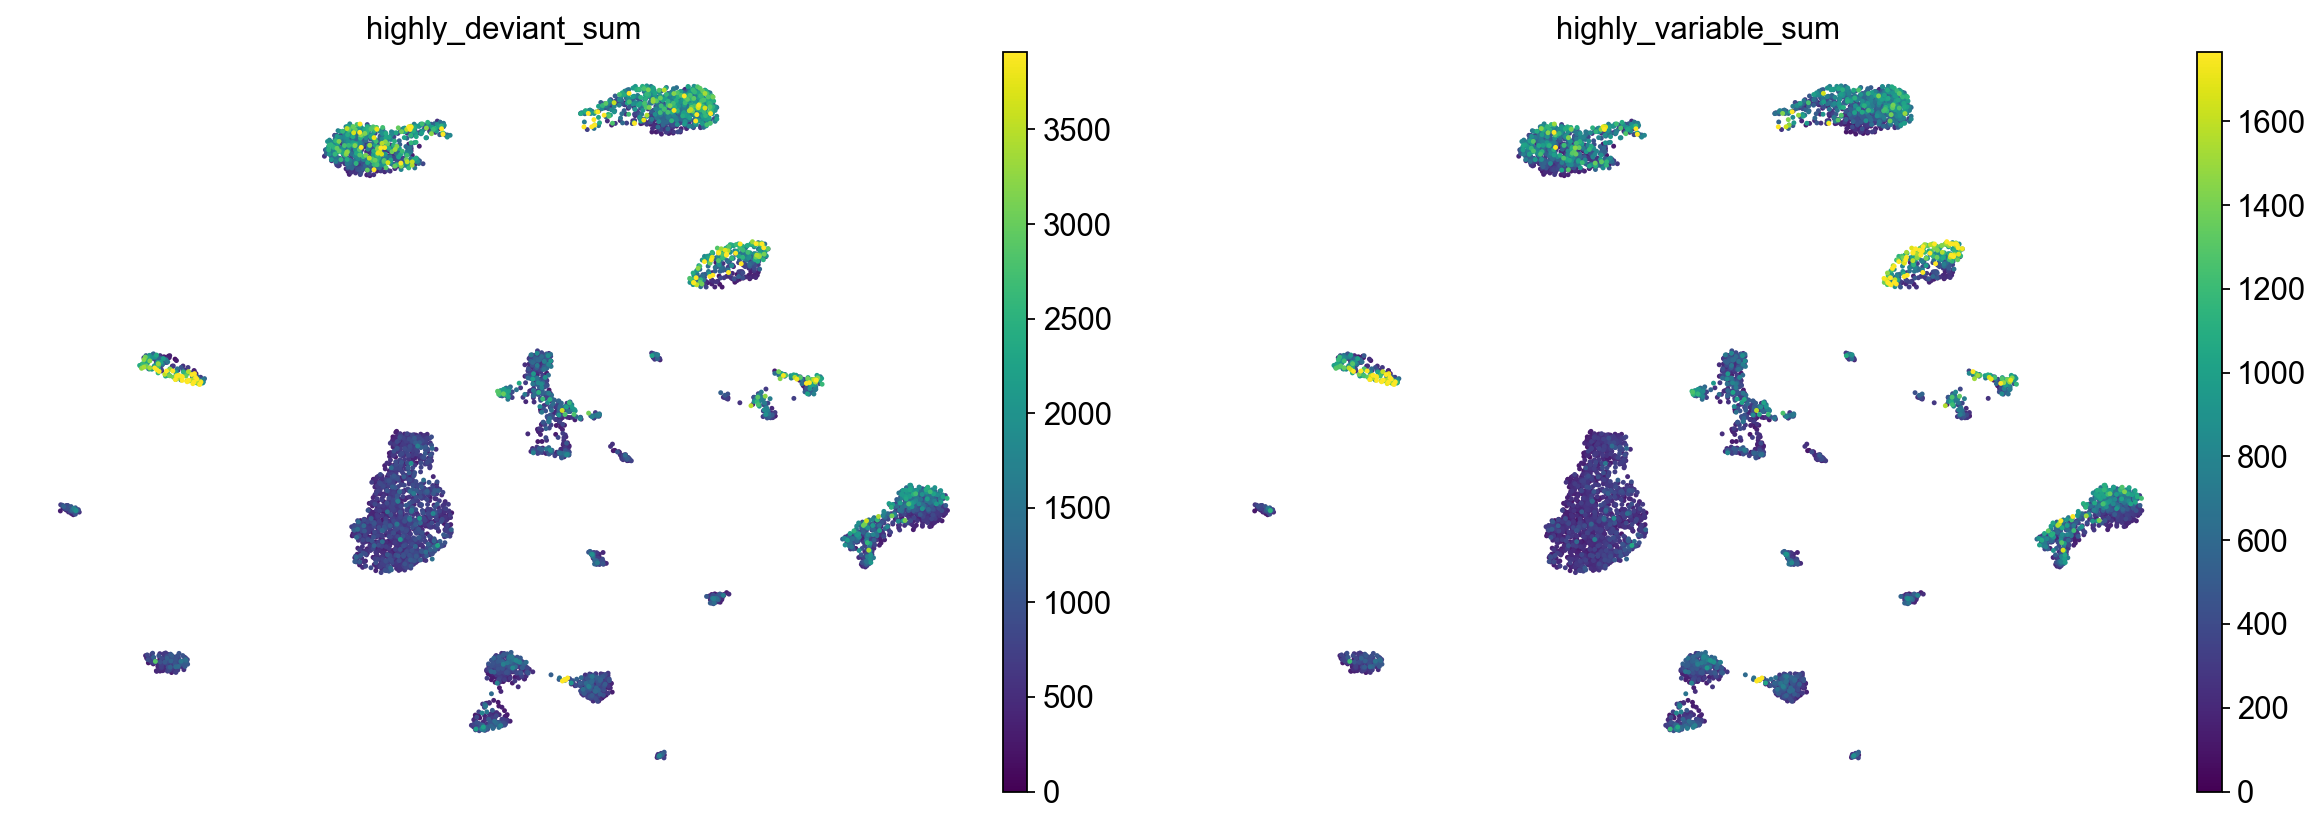

In [93]:
# Color UMAP by cell's sum of deviant & variable genes.
adata.obs['highly_deviant_sum'] = adata[:, adata.var['highly_deviant']].X.sum(axis=1)
adata.obs['highly_variable_sum'] = adata[:, adata.var['highly_variable']].X.sum(axis=1)

sc.pl.umap(
    adata,
    color=['highly_deviant_sum', 'highly_variable_sum'],
    ncols=2,
    vmin=0, 
    vmax="p99"
)

In [94]:
# Extract most influencial genes from first Principle Component
top_genes_pc1 = adata.var_names[abs(adata.varm['PCs'][:, 0]).argsort()[::-1][:15]].tolist()

top_genes_pc1

['LIMCH1',
 'NCKAP5',
 'SFTPB',
 'NEDD4L',
 'RBMS3',
 'PARP8',
 'SKAP1',
 'AOAH',
 'PDE4D',
 'MAGI3',
 'LMO7',
 'EMP2',
 'PIP4K2A',
 'PRKG1',
 'ALCAM']

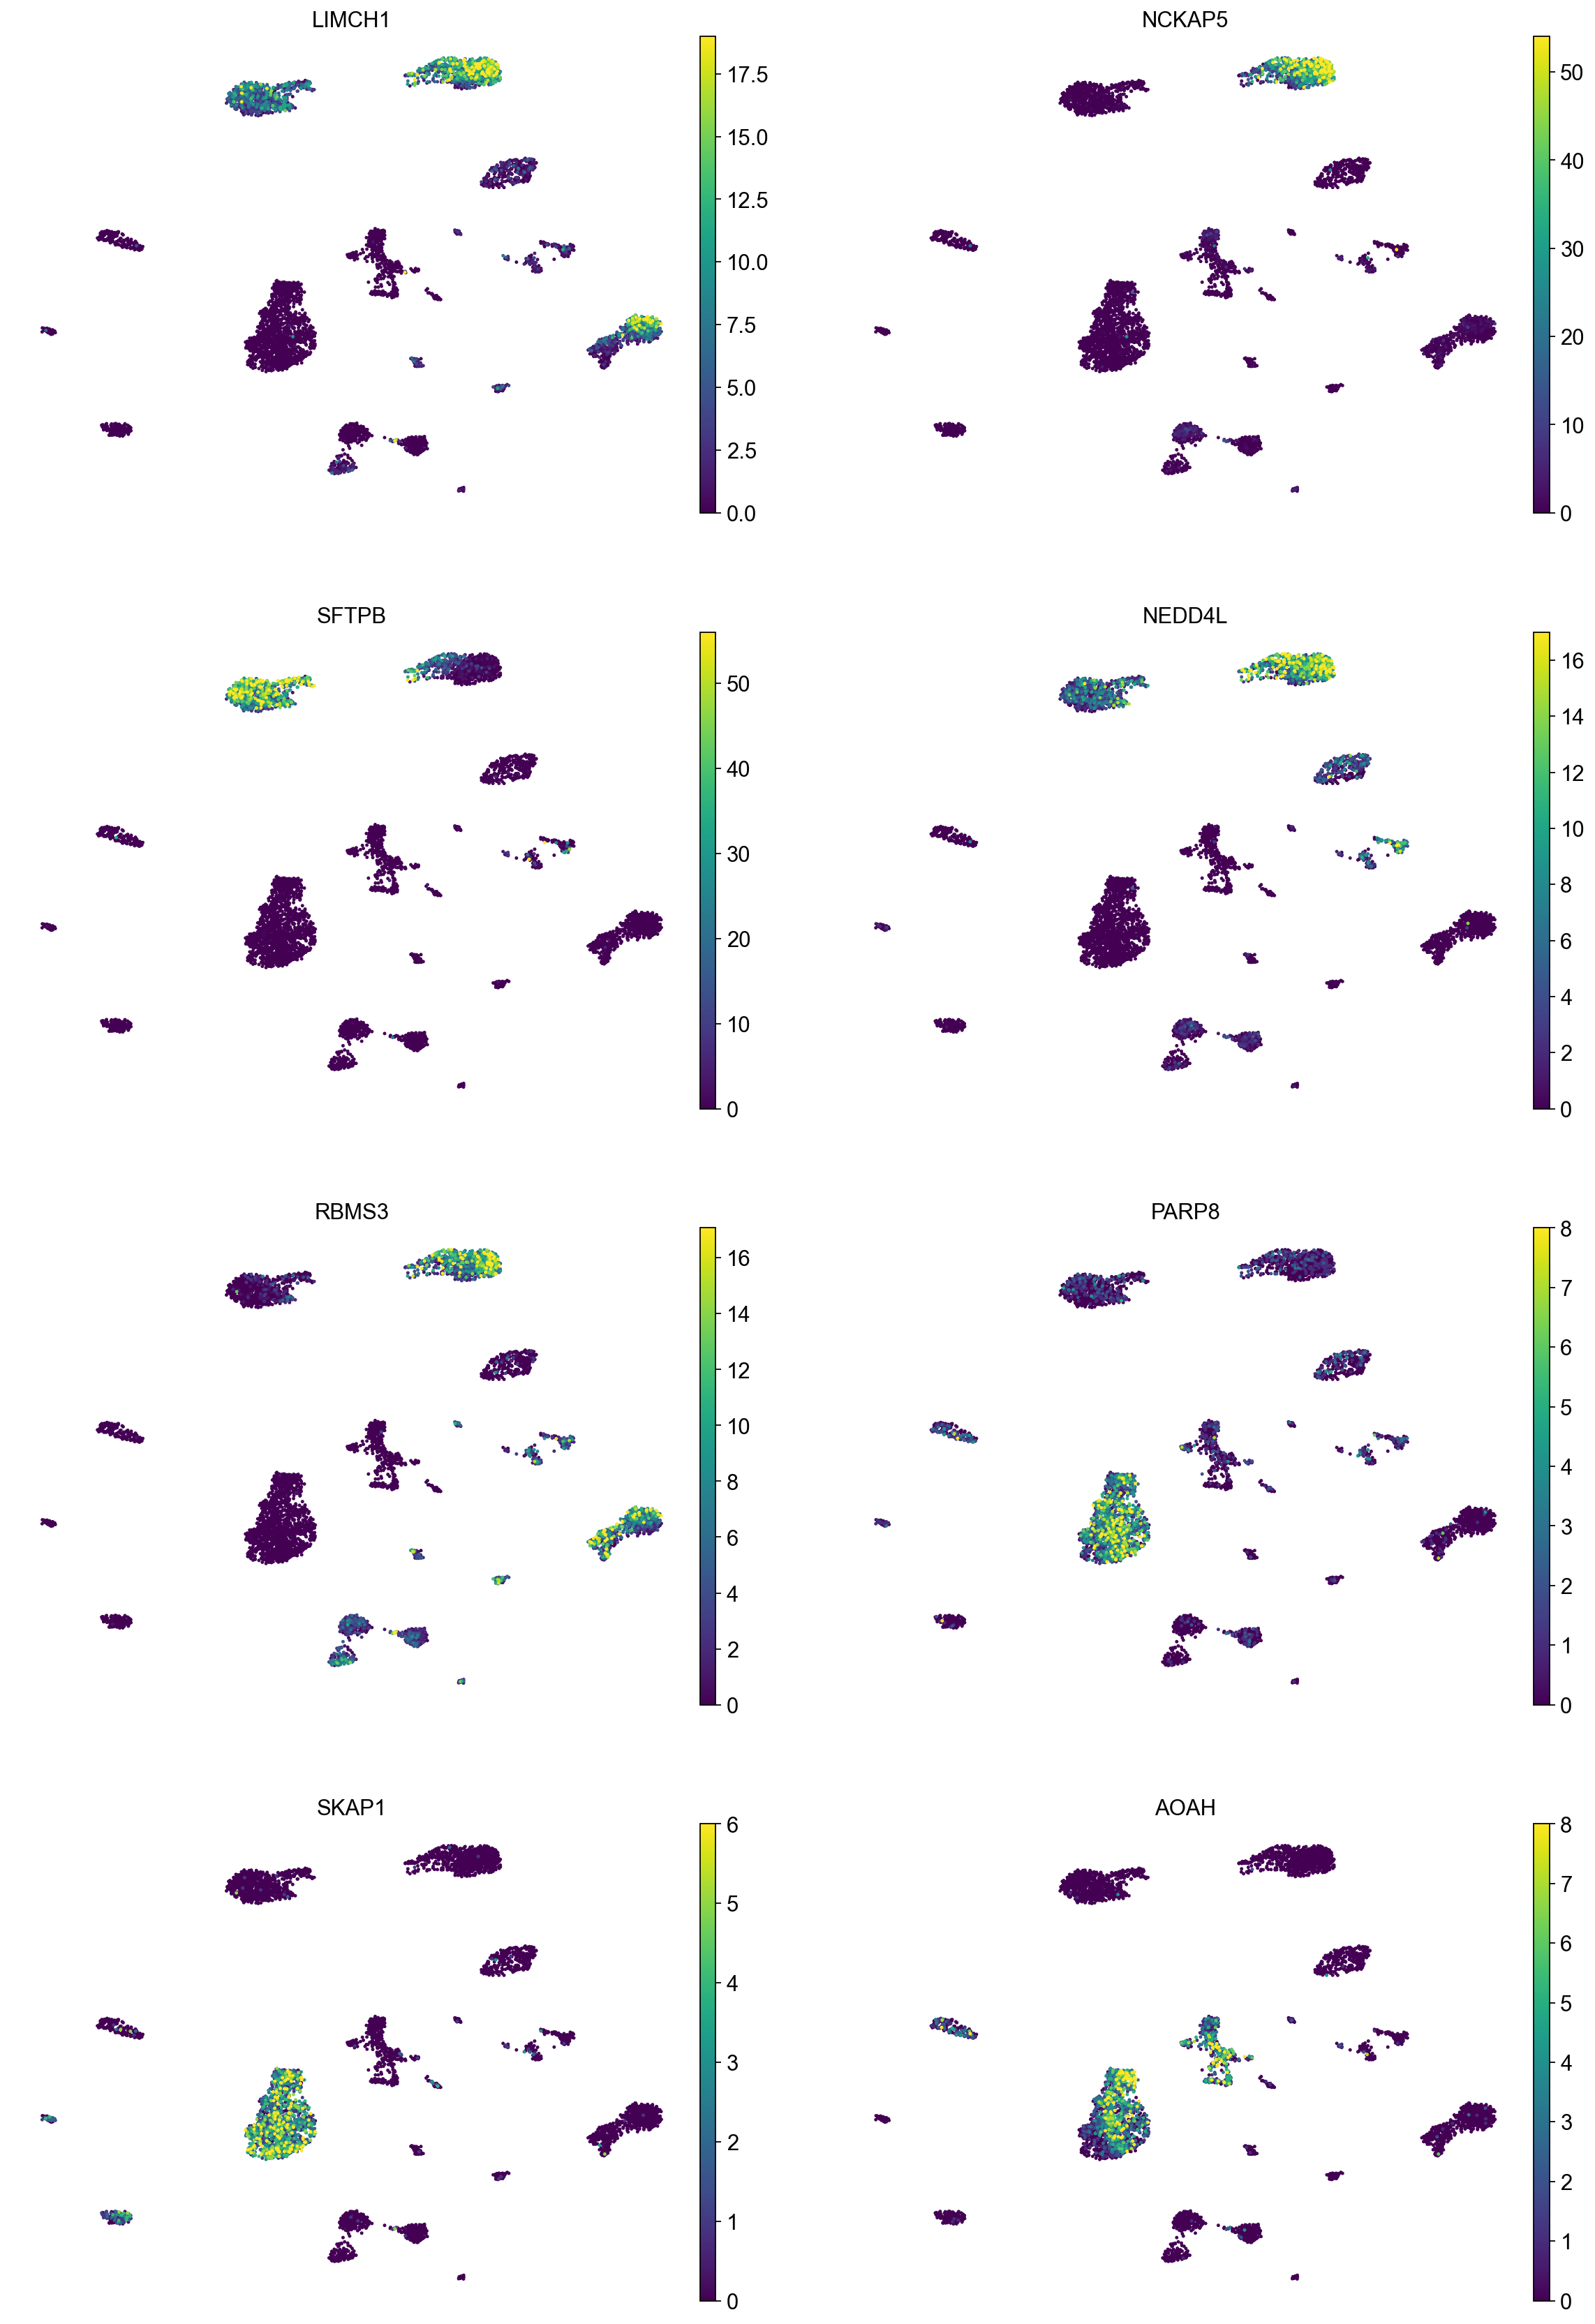

In [95]:
# Check Top markers
sc.pl.umap(adata, color=top_genes_pc1[:8], ncols=2, vmin=0, vmax="p99")

# Define Cell Boundries

In order to computationally determine the cluster assignments, we utlize Leiden clustering. [From Louvain to Leiden: guaranteeing well-connected communities](https://www.nature.com/articles/s41598-019-41695-z). Leiden clustering uses K Nearest Neighbores (KNN) method to groups cells based on a predefined (but meaningless) resolution metric (default is 1.0, higher values product more clusters). This requires some refinement and can be further optimized by increasing the resolution of a subcluster. 

In [96]:
# Call Leiden algoritm with various resolutions 
for res in [0.02, 0.5, 1.0, 2.0]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}", resolution=res) # flavor="igraph", n_iterations=2)
    
adata

AnnData object with n_obs × n_vars = 6094 × 24660
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'size_factors', 'highly_deviant_sum', 'highly_variable_sum', 'leiden_res_0.02', 'leiden_res_0.50', 'leiden_res_1.00', 'leiden_res_2.00'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_deviant', 'binomial_deviance', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'outlier_temp_colors', 'pca', 'tsne', 'neighbors', 'umap', 'leiden_res_0.02', 'leiden_res_0.50', 'leiden_res_1.00', 'leiden_res_2.00'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'l

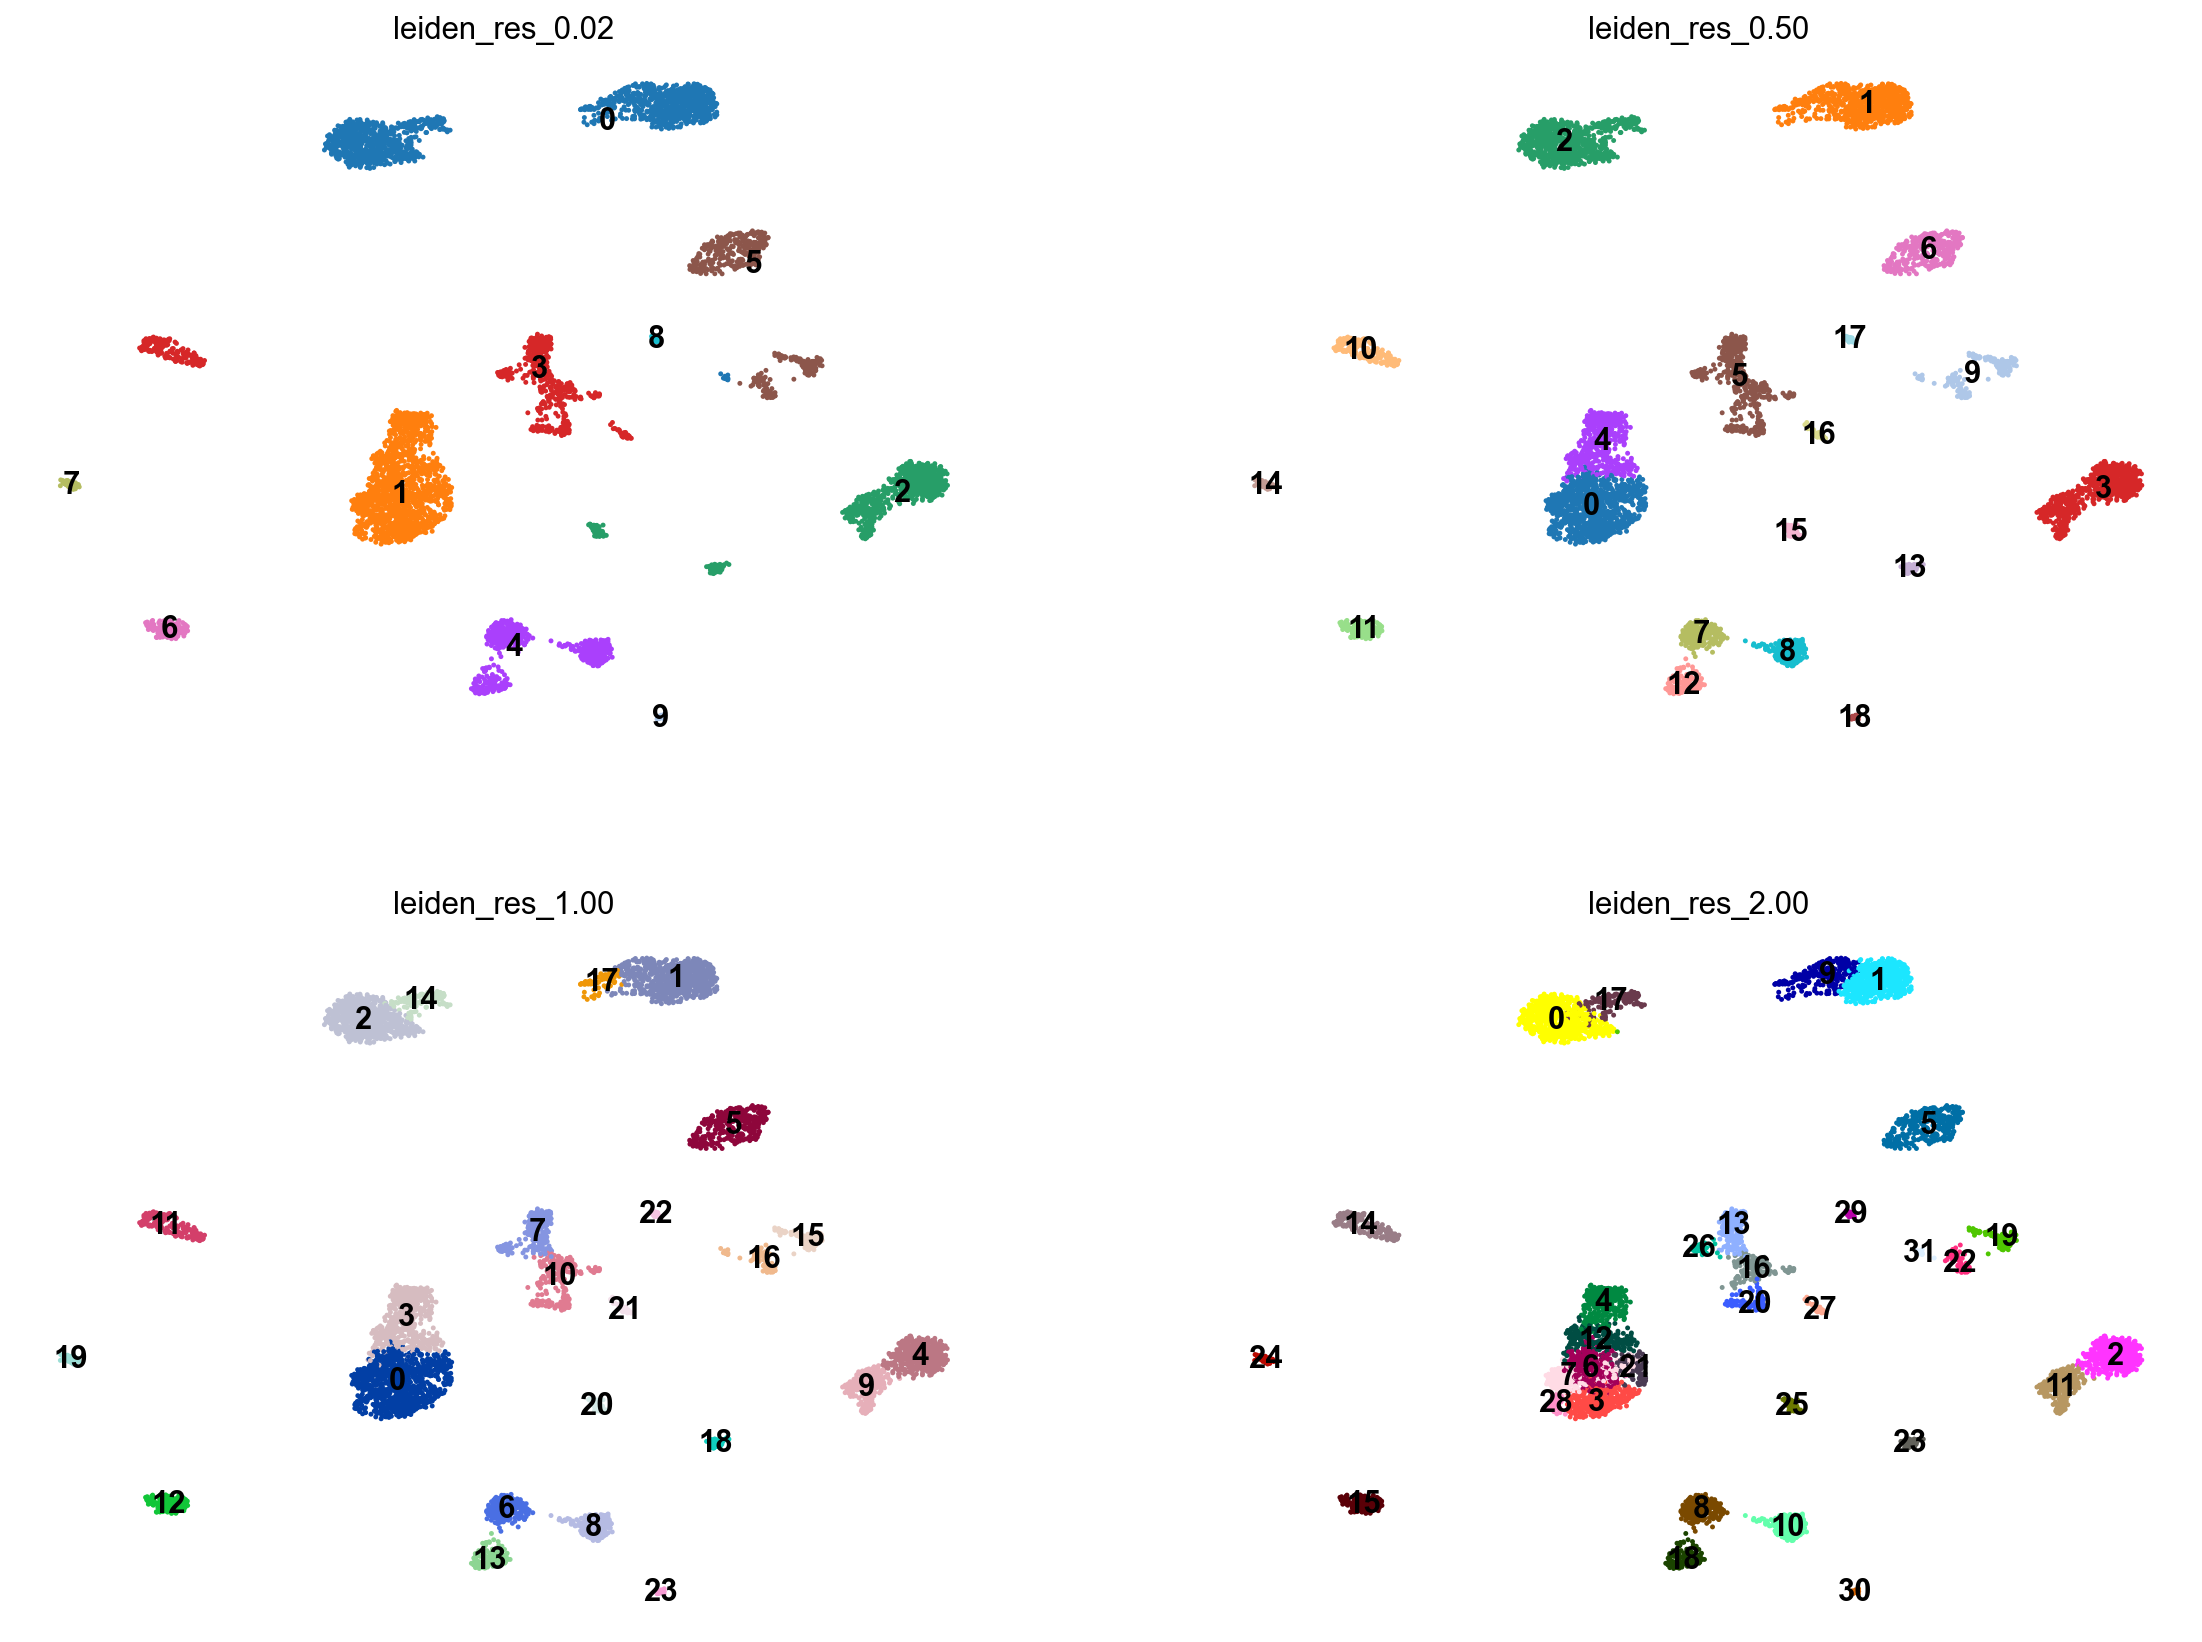

In [97]:
# Visualize outputs
sc.pl.umap(
    adata,
    color=["leiden_res_0.02", "leiden_res_0.50", "leiden_res_1.00", "leiden_res_2.00"],
    legend_loc="on data",
    ncols=2
)

The choice of clustering resolution can be a arbetrary choice in many ways. Yet various coarse and fine clustering approaches offer benefits towards annotating our cells. Ulitmately the ground truth for grouping our cells depends highly on our question of interest and on the level of expertise we can muster.

My personal experiance with single cell data is mostly within mouse lungs using flourescent protein tagging methods of imaging and flow cytometry. This doesnt provide me with the level of experitice to confidentally label all cell types, but i should be able to identify some major cell types given that protein identification will suffice with RNA signatures at hand. 

Additionally plenty of resources exist that can help in identification of cell types. 
**Manual Annotation**
- [PanglaoDB](https://panglaodb.se/index.html)
    - [rPanglaoDB](https://github.com/dosorio/rPanglaoDB): R package to query PanglaoDB
- [The Molecular Signatures Database (MSigDB)](https://www.gsea-msigdb.org/gsea/msigdb)
- [Tabula Muris](https://tabula-muris.sf.czbiohub.org/)
- [CellMarker 2.0](http://bio-bigdata.hrbmu.edu.cn/CellMarker/)

**Reference Annotation**
- [Azimuth](https://azimuth.hubmapconsortium.org/)
- [Tabula Sapiens](https://tabula-sapiens.sf.czbiohub.org/)
- [Single Cell Identificator Based on E-test (SciBet)](http://scibet.cancer-pku.cn/)


Fortunatly, the original authors of the dataset have provided an immense amount of information regarding their analysis. Including gene signatures they used for annotation. But first i will try my own hand at the task. 

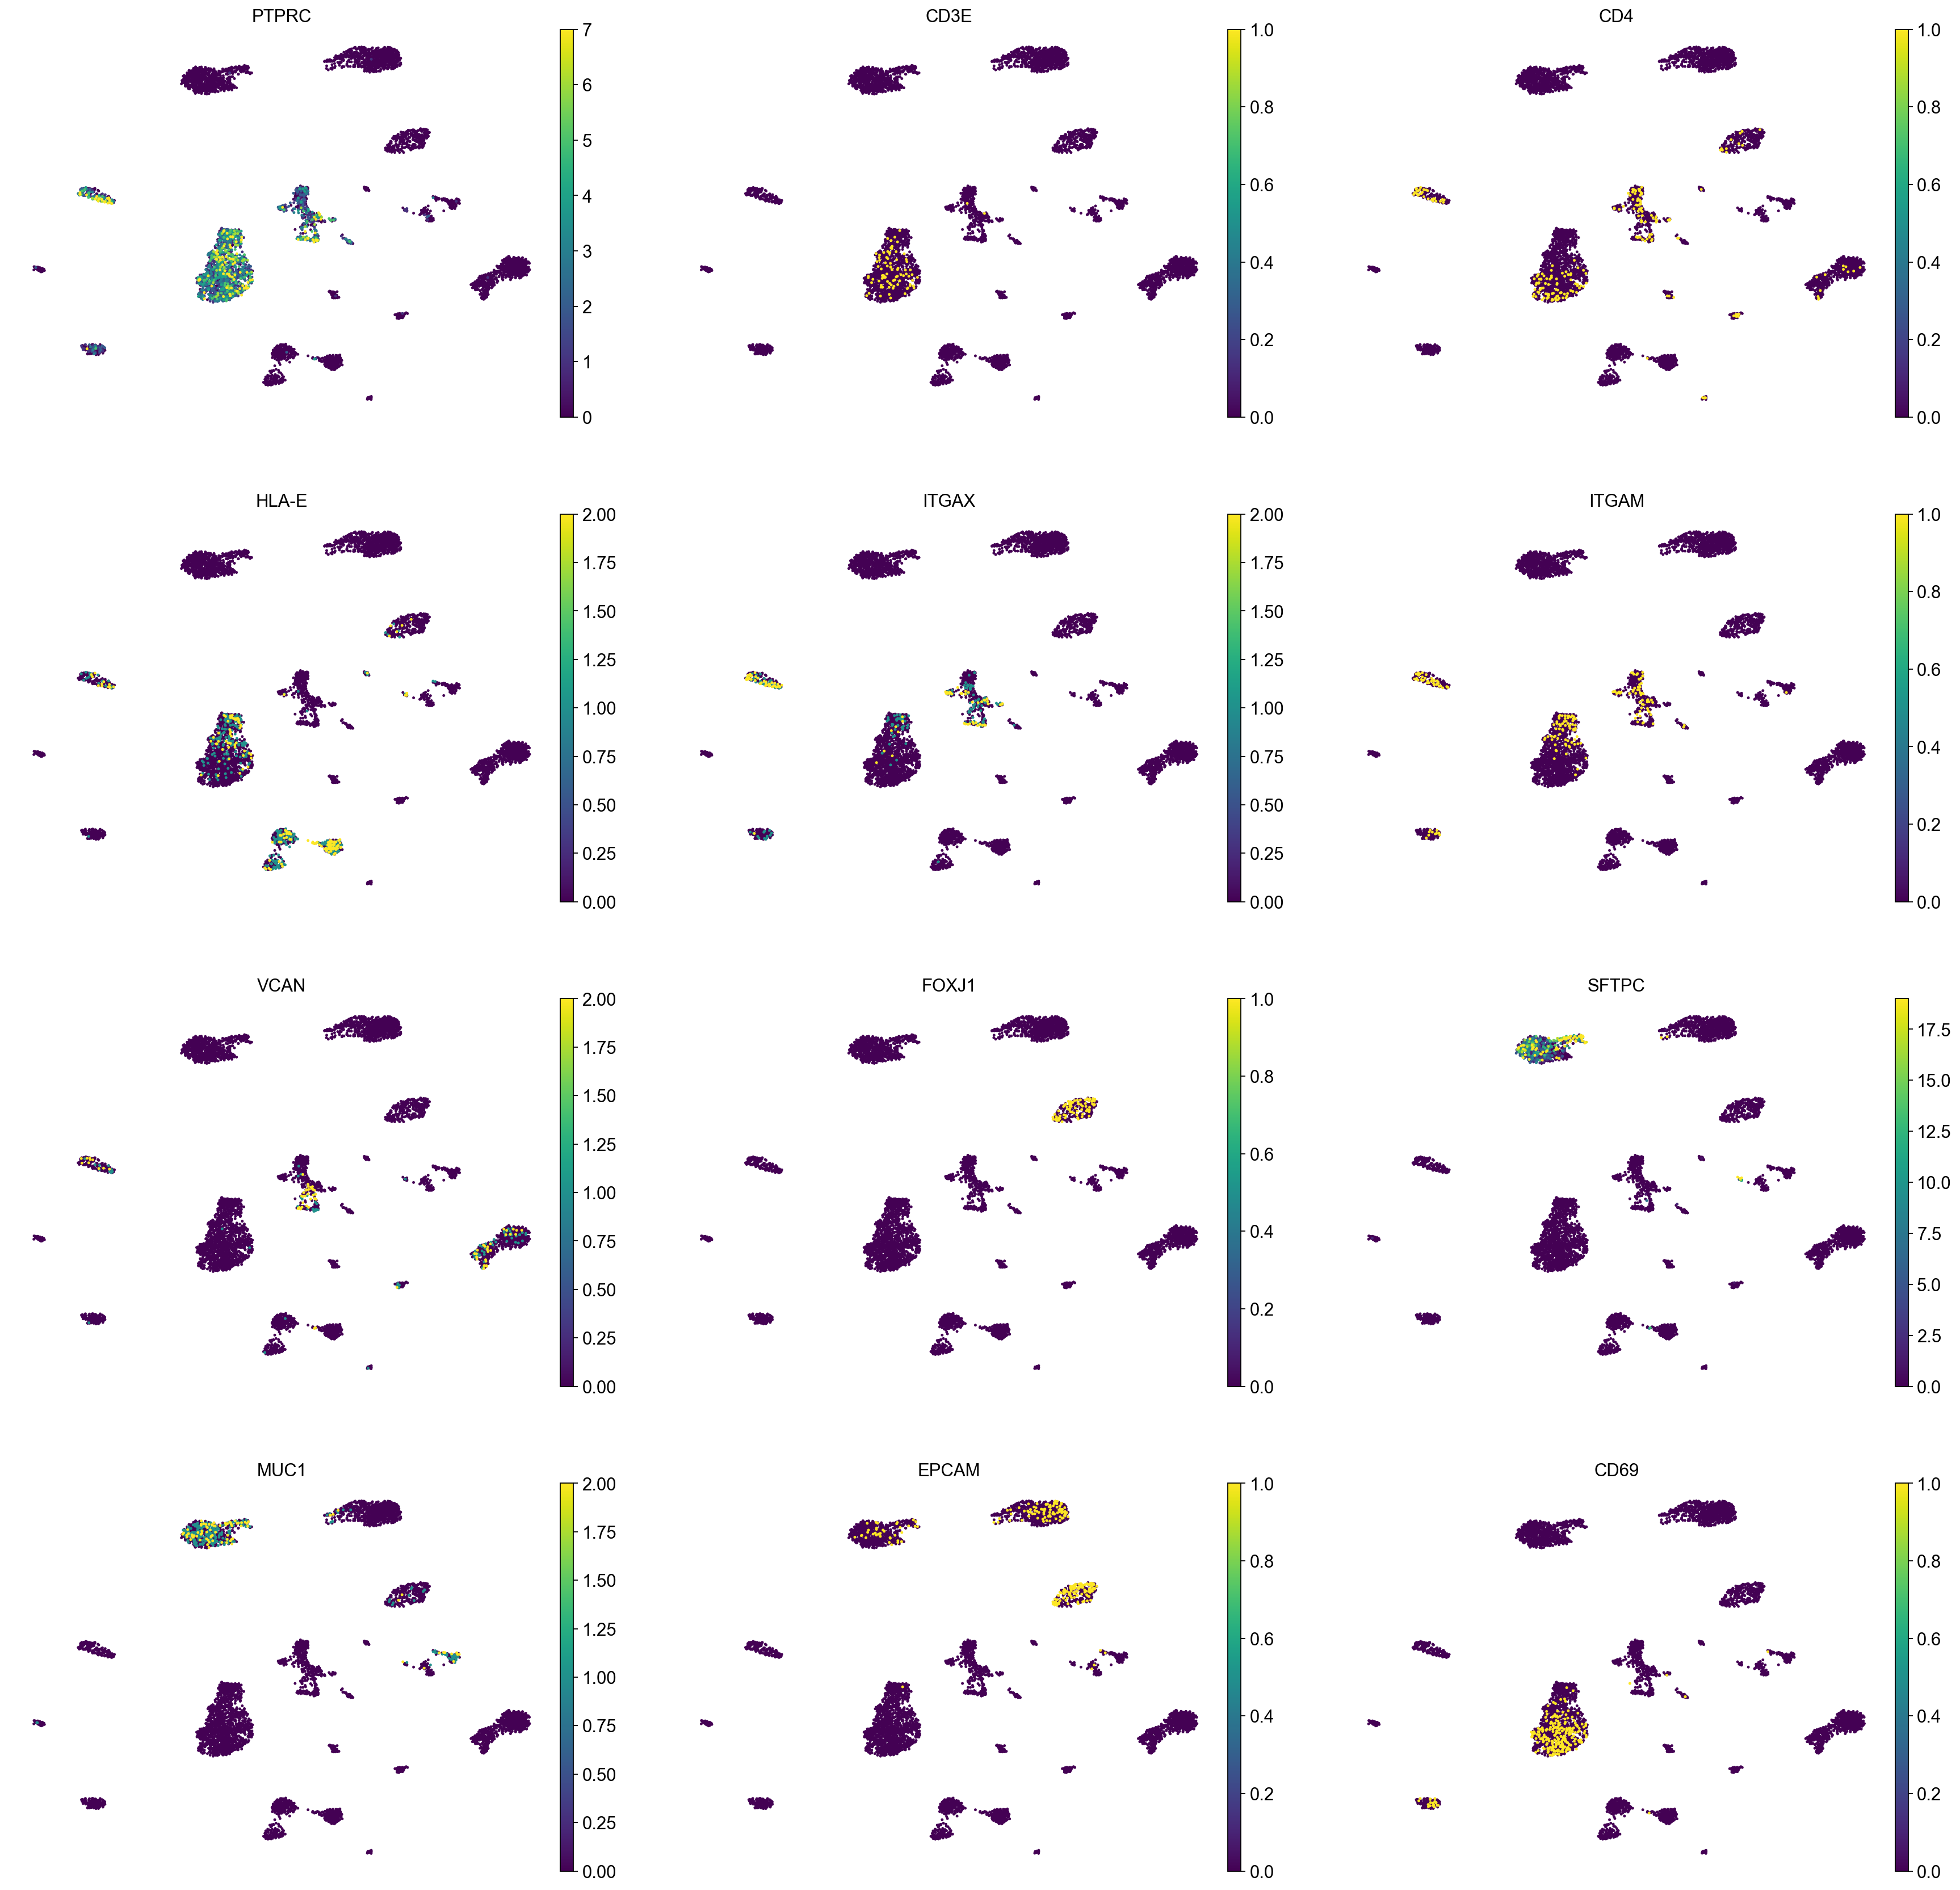

In [98]:
# Common markers List to compare feature selection methods
markers = ["PTPRC", "CD3E", "CD4", "HLA-E", "ITGAX", "ITGAM", "VCAN", "FOXJ1", "SFTPC", "MUC1", "EPCAM", "CD69"] # low expression "IGHM", "CD14", "CCR2", "CD19"

# Color by chosen markers
sc.pl.umap(adata, color=markers, ncols=3, vmax="p99")

Some common markers such as CD8 were not in the genelist, but with this brief inspection into some other well known markers, im fairly comfortable with the clustering results at this point. I think i could comfortably annotate the cells by myself at a resolution of 0.5 but i believe the default resolution of 1.0 seems to provide an appropriate end point.  

At this point, i would finalize my exploration of this and previous notebooks and consolidate my decision into a single function to integrate the remaining samples.
This will be a computationally expensive task that could benefit from code/performance optimization and even cloud computing depending on the number of samples and the size of the datasets.

## Save Object

In [99]:
# Save object
adata.write("data/C51ctr_Clustered.h5ad")

# End Session

In [100]:
import session_info
session_info.show()

c:\Users\Owner\Documents\GitHub\scRNA_Lethal_Covid19_Analysis\.venv\Lib\site-packages\session_info\main.py:213: UserWarning: The '__version__' attribute is deprecated and will be removed in MarkupSafe 3.1. Use feature detection, or `importlib.metadata.version("markupsafe")`, instead.
  mod_version = _find_version(mod.__version__)
